In [1]:
import numpy as np

import os

In [5]:
rollout_dir = "/mnt/c/Users/narun/Desktop/Project/Heat_MGN/rollouts/testset"
testcases = os.listdir(rollout_dir)
rollouts = {}
for case in testcases :
    if case.startswith("square") :
        rollouts[case] = np.load(os.path.join(rollout_dir, case, "rollout.npz"))


In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=[0, 100, 200], cmap='viridis', point_size=4, output_filename = ""):
    """
    Scatter plot of predicted vs ground truth temperature for selected timesteps.
    Each timestep uses a different color, and a legend shows which color corresponds to which step.

    Args:
        pred (torch.Tensor or np.ndarray): shape (T, N) = (timesteps, nodes)
        gt (torch.Tensor or np.ndarray): same shape
        timesteps (list[int]): which timesteps to plot (e.g. [0, 100, 200])
        cmap (str): matplotlib colormap name
        point_size (int): size of scatter points
    """
    # Convert to numpy
    if hasattr(pred, 'detach'):
        pred = pred.detach().cpu().numpy()
    if hasattr(gt, 'detach'):
        gt = gt.detach().cpu().numpy()

    T, N = pred.shape
    timesteps = [t for t in timesteps if t < T]  # clip to available range

    colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors

    plt.figure(figsize=(6, 6))
    for i, t in enumerate(timesteps):
        plt.scatter(
            gt[t], pred[t],
            s=point_size,
            color=colors(i),
            alpha=0.6,
            label=f"Timestep {int((t+1)/pred.shape[0] * 100)}%"
        )

    # 45° reference line
    min_val = min(gt.min(), pred.min())
    max_val = max(gt.max(), pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1.5)

    plt.xlabel("Ground Truth Temperature (K)")
    plt.ylabel("Predicted Temperature (K)")
    plt.title(f"Pred vs GT Temperature for the square scanning case")
    plt.legend(markerscale=3, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_filename, dpi=600, bbox_inches='tight', pad_inches=0.02)
    print(f"Saved high-resolution figure to: {output_filename}")
    plt.show()


In [66]:
# for triple tracks case
case_name = list(rollouts.keys())[0]
rollout = rollouts[case_name]

/tmp/ipykernel_145292/501148435.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap, len(timesteps))  # evenly spaced colors


Saved high-resolution figure to: /mnt/c/Users/narun/Desktop/Project/Heat_MGN/figures/square_temperature_gt_pred_isoline.png


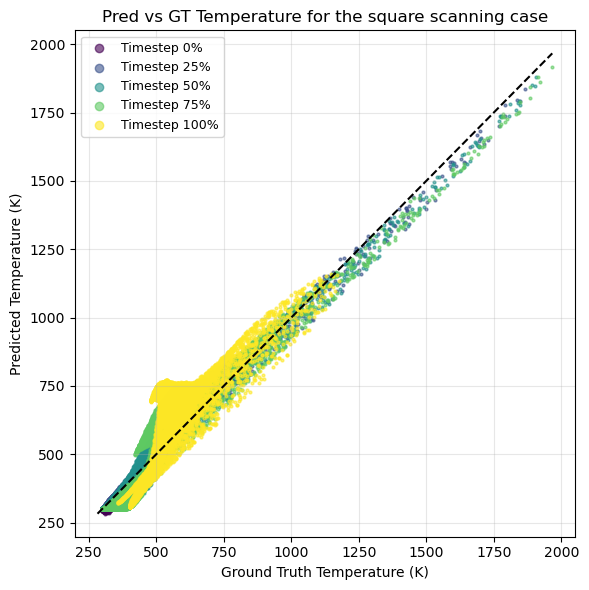

In [67]:
pred = rollout["pred"]
gt = rollout["gt"]
# selected_timesteps = [pred.shape[0]-1]
selected_timesteps = [0, int(pred.shape[0] * 0.25), int(pred.shape[0] * 0.5), int(pred.shape[0] * 0.75), pred.shape[0]-1]
output_filename = "/mnt/c/Users/narun/Desktop/Project/Heat_MGN/figures/" + f"square_temperature_gt_pred_isoline.png"
plot_pred_vs_gt_selected(case_name, pred, gt, timesteps=selected_timesteps, cmap='viridis', point_size=4, output_filename = output_filename)

In [16]:
data = rollout

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_slices_with_meltpool(mesh_pos, pred, gt, timestep, y_val, nx=50, ny=50, nz=50, threshold=0.5):
    """
    Plot XY (top Z-plane) and XZ (at y_val) slices for pred, gt, and error.
    Overlay meltpool contours and annotate meltpool dimensions.
    
    Each case (pred, gt, error) gets its own shared colorbar between XY and XZ slices.
    """
    # Extract timestep
    pred_t = pred[timestep, :]
    gt_t = gt[timestep, :]
    err_t = np.abs(pred_t - gt_t)
    
    # Interpolation grid
    x_lin = np.linspace(mesh_pos[:,0].min(), mesh_pos[:,0].max(), nx)
    y_lin = np.linspace(mesh_pos[:,1].min(), mesh_pos[:,1].max(), ny)
    z_lin = np.linspace(mesh_pos[:,2].min(), mesh_pos[:,2].max(), nz)
    X, Y, Z = np.meshgrid(x_lin, y_lin, z_lin, indexing='ij')

    # Interpolate
    grid_pred = griddata(mesh_pos, pred_t, (X, Y, Z), method='linear')
    grid_gt = griddata(mesh_pos, gt_t, (X, Y, Z), method='linear')
    grid_err = np.abs(grid_pred - grid_gt)
    
    dx = x_lin[1] - x_lin[0]
    dy = y_lin[1] - y_lin[0]
    dz = z_lin[1] - z_lin[0]
    
    # Meltpool function
    def compute_meltpool(grid):
        mask = grid >= threshold
        if not mask.any():
            return 0,0,0,0
        x_coords = x_lin[np.any(np.any(mask, axis=1), axis=1)]
        y_coords = y_lin[np.any(np.any(mask, axis=0), axis=1)]
        z_coords = z_lin[np.any(np.any(mask, axis=0), axis=0)]
        melt_x = x_coords.max() - x_coords.min()
        melt_y = y_coords.max() - y_coords.min()
        melt_z = z_coords.max() - z_coords.min()
        melt_vol = np.sum(mask) * dx * dy * dz
        return float(melt_x), float(melt_y), float(melt_z), float(melt_vol)

    # Find nearest y index for XZ slice
    y_idx = np.abs(y_lin - y_val).argmin()

    # Prepare slices
    slices = {
        'pred': grid_pred,
        'gt': grid_gt,
        'error': grid_err
    }
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    for i, (label, grid) in enumerate(slices.items()):
        # Determine vmin/vmax for this row
        vmin = np.nanmin(grid)
        vmax = np.nanmax(grid)

        # XY top Z-plane
        im1 = axes[i,0].imshow(grid[:, :, -1].T, origin='lower',
                               extent=[x_lin[0], x_lin[-1], y_lin[0], y_lin[-1]],
                               vmin=vmin, vmax=vmax)
        axes[i,0].contour(x_lin, y_lin, grid[:, :, -1].T, levels=[threshold], colors='r')
        axes[i,0].set_title(f'{label} XY top Z-plane')
        axes[i,0].set_xlabel('X')
        axes[i,0].set_ylabel('Y')
        axes[i,0].text(0.5, -0.15, f'Meltpool dims (X,Y,Z,Vol): {compute_meltpool(grid)}',
                       transform=axes[i,0].transAxes, ha='center', va='top')
        
        # XZ at selected Y-plane
        im2 = axes[i,1].imshow(grid[:, y_idx, :].T, origin='lower',
                               extent=[x_lin[0], x_lin[-1], z_lin[0], z_lin[-1]],
                               vmin=vmin, vmax=vmax)
        axes[i,1].contour(x_lin, z_lin, grid[:, y_idx, :].T, levels=[threshold], colors='r')
        axes[i,1].set_title(f'{label} XZ at Y={y_val:.2f}')
        axes[i,1].set_xlabel('X')
        axes[i,1].set_ylabel('Z')
        axes[i,1].text(0.5, -0.15, f'Meltpool dims (X, Y, Z): {compute_meltpool(grid)[0]:.2f}, {compute_meltpool(grid)[1]:.2f}, {compute_meltpool(grid)[2]:.2f}',
                       transform=axes[i,1].transAxes, ha='center', va='top')

        # Shared colorbar for this row
        cbar = fig.colorbar(im1, ax=[axes[i,0], axes[i,1]], orientation='vertical', fraction=0.03, pad=0.02)
        cbar.set_label('Value')
    
    plt.tight_layout()
    plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

def plot_slices_with_meltpool(mesh_pos, pred, gt, timestep, y_val, nx=50, ny=50, nz=50,
                                      threshold=0.5, tick_step=5, levels=20, output_filename = ""):
    """
    Columns: pred | gt | error
    Rows: XY top plane, XZ at selected Y
    XZ row thinner (1:3 ratio)
    Filled contour plots, threshold overlay, meltpool annotations, horizontal colorbars below XZ
    """
    pred_t = pred[timestep, :]
    gt_t = gt[timestep, :]
    err_t = np.abs(pred_t - gt_t)

    # Grid
    x_lin = np.linspace(mesh_pos[:,0].min(), mesh_pos[:,0].max(), nx)
    y_lin = np.linspace(mesh_pos[:,1].min(), mesh_pos[:,1].max(), ny)
    z_lin = np.linspace(mesh_pos[:,2].min(), mesh_pos[:,2].max(), nz)
    X, Y, Z = np.meshgrid(x_lin, y_lin, z_lin, indexing='ij')

    # Interpolation
    grid_pred = griddata(mesh_pos, pred_t, (X, Y, Z), method='linear')
    grid_gt = griddata(mesh_pos, gt_t, (X, Y, Z), method='linear')
    grid_err = np.abs(grid_pred - grid_gt)

    dx = x_lin[1] - x_lin[0]
    dy = y_lin[1] - y_lin[0]
    dz = z_lin[1] - z_lin[0]

    def compute_meltpool(grid):
        mask = grid >= threshold
        if not mask.any(): return 0,0,0,0
        x_coords = x_lin[np.any(np.any(mask, axis=1), axis=1)]
        y_coords = y_lin[np.any(np.any(mask, axis=0), axis=1)]
        z_coords = z_lin[np.any(np.any(mask, axis=0), axis=0)]
        melt_x = x_coords.max() - x_coords.min()
        melt_y = y_coords.max() - y_coords.min()
        melt_z = z_coords.max() - z_coords.min()
        melt_vol = np.sum(mask) * dx * dy * dz
        return melt_x, melt_y, melt_z, melt_vol

    y_idx = np.abs(y_lin - y_val).argmin()
    slices = {'$T_{pred}$ (K)': grid_pred, '$T_{gt}$ (K)': grid_gt, 'Error (K)': grid_err}

    # GridSpec for XY/XZ row ratio 3:1
    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, 3, height_ratios=[3,1], hspace=0.2, wspace=0.3)

    for j, (label, grid) in enumerate(slices.items()):
        vmin, vmax = np.nanmin(grid), np.nanmax(grid)

        # XY filled contour
        ax_xy = fig.add_subplot(gs[0,j])
        cf_xy = ax_xy.contourf(x_lin, y_lin, grid[:,:, -1].T, levels=levels, vmin=vmin, vmax=vmax, cmap='viridis')
        ax_xy.contour(x_lin, y_lin, grid[:,:, -1].T, levels=[threshold], colors='r', linewidths=1.5)
        ax_xy.set_title(f'{label} XY top Z-plane')
        ax_xy.set_ylabel('Y (m)')
        ax_xy.set_aspect('auto')
        ax_xy.set_xlim(x_lin[0], x_lin[-1])
        ax_xy.set_xticks([x_lin[0], 0.5*(x_lin[0]+x_lin[-1]), x_lin[-1]])

        # # XZ filled contour
        # ax_xz = fig.add_subplot(gs[1,j])
        # cf_xz = ax_xz.contourf(x_lin, z_lin, grid[:,y_idx,:].T, levels=levels, vmin=vmin, vmax=vmax, cmap='viridis')
        # ax_xz.contour(x_lin, z_lin, grid[:,y_idx,:].T, levels=[threshold], colors='r', linewidths=1.5)
        # ax_xz.set_title(f'{label} XZ at Y={y_val * 1000 :.2f} mm')
        ax_xy.set_xlabel('X (m)')
        # ax_xz.set_ylabel('Z (m)')
        # ax_xz.set_aspect('auto')
        # ax_xz.set_xlim(x_lin[0], x_lin[-1])
        # ax_xz.set_xticks([x_lin[0], 0.5*(x_lin[0]+x_lin[-1]), x_lin[-1]])

        # Meltpool annotation below XZ
        if label != "Error (K)":
            ax_xy.text(0.5, -0.11,
                       f'Meltpool dims (X,Y,Z): ({compute_meltpool(grid)[0]*1000:.2f}, {compute_meltpool(grid)[1]*1000:.2f}, {compute_meltpool(grid)[2]*1000:.2f}) mm',
                       transform=ax_xy.transAxes, ha='center', va='top')

        # Horizontal colorbar below XZ
        divider = make_axes_locatable(ax_xy)
        cax = divider.append_axes("bottom", size="5%", pad=0.7)
        cbar = fig.colorbar(cf_xy, cax=cax, orientation='horizontal')
        cbar.set_label(label)

    plt.suptitle(f"Temperature distribution (K) of the square scanning case at timestep {int(timestep/pred.shape[0] * 100)} %", fontsize = 14 )
    plt.tight_layout()
    plt.savefig(output_filename, dpi=600, bbox_inches='tight', pad_inches=0.02)
    print(f"Saved high-resolution figure to: {output_filename}")
    plt.show()


In [53]:
pred.shape

(1318, 8647)

/tmp/ipykernel_145292/1630502905.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved high-resolution figure to: /mnt/c/Users/narun/Desktop/Project/Heat_MGN/figures/square_temperature_timestep_1200.png


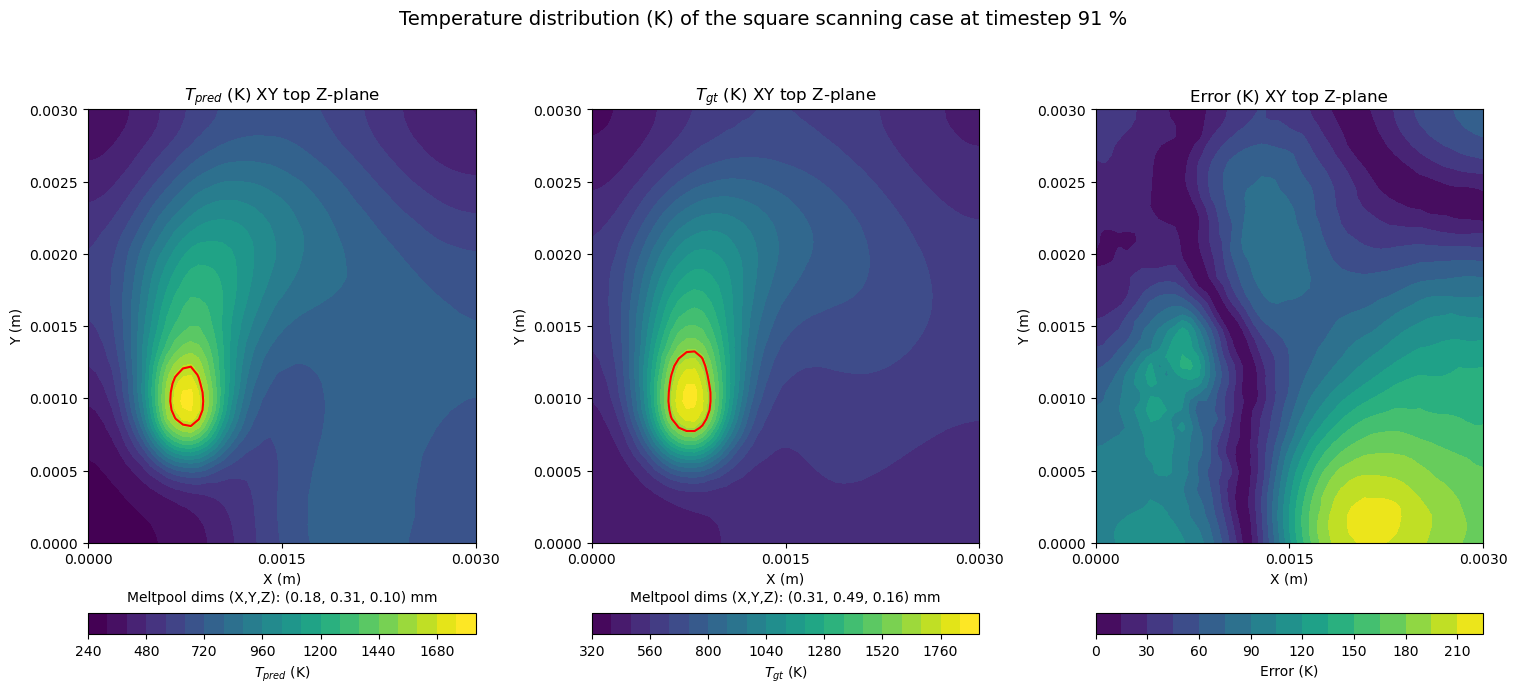

In [56]:
mesh_pos = data["mesh_pos"]
i = 5
timesteps = [200, 400, 600, 800, 1000, 1200]
y_vals = [0.0005, 0.0015, 0.0025, 0, 0, 0 ]
output_filename = "/mnt/c/Users/narun/Desktop/Project/Heat_MGN/figures/" + f"square_temperature_timestep_{timesteps[i]}.png"  # customize name as needed
plot_slices_with_meltpool(mesh_pos, pred, gt, timestep=timesteps[i], y_val=y_vals[i], nx=50, ny=50, nz=50, threshold=1618, tick_step=7, output_filename = output_filename)


In [60]:
import numpy as np

def compute_tetra_volume(p0, p1, p2, p3):
    """Compute volume of a tetrahedron given node positions"""
    return abs(np.dot(np.cross(p1 - p0, p2 - p0), p3 - p0)) / 6.0

def compute_meltpool(mesh_pos, cells, temperature, threshold):
    """
    Compute meltpool dimensions and volume directly from mesh.

    Parameters:
        mesh_pos (Nx3): Node coordinates
        cells (Mx4): Tetrahedron connectivity
        temperature (N): Scalar field at nodes
        threshold (float): Melt threshold
    Returns:
        melt_x, melt_y, melt_z, melt_volume
    """
    # 1. Identify melted nodes
    melted_nodes = np.where(temperature >= threshold)[0]
    if melted_nodes.size == 0:
        return 0, 0, 0

    # 2. Melt dimensions (bounding box)
    melted_coords = mesh_pos[melted_nodes]
    melt_x = melted_coords[:, 0].max() - melted_coords[:, 0].min()
    melt_y = melted_coords[:, 1].max() - melted_coords[:, 1].min()
    melt_z = melted_coords[:, 2].max() - melted_coords[:, 2].min()

    # # 3. Melt volume (sum tetra volumes with any melted node)
    # melt_volume = 0.0
    # for cell in cells:
    #     # Check if any node in cell is melted
    #     if np.any(np.isin(cell, melted_nodes)):
    #         p0, p1, p2, p3 = mesh_pos[cell[0]], mesh_pos[cell[1]], mesh_pos[cell[2]], mesh_pos[cell[3]]
    #         melt_volume += compute_tetra_volume(p0, p1, p2, p3)

    return melt_x, melt_y, melt_z


In [61]:
pred.shape[0]

1318

In [63]:
pred_melt_x_list, pred_melt_y_list, pred_melt_z_list = [], [], []
gt_melt_x_list, gt_melt_y_list, gt_melt_z_list = [], [], []
times = np.arange(pred.shape[0])  # or np.arange(pred.shape[0])
threshold = 1618  # Adjust based on your data

for timestep in range(pred.shape[0]):
    temp_t = pred[timestep, :]  # temperature at nodes at this timestep
    melt_x, melt_y, melt_z = compute_meltpool(mesh_pos, data["cells"], temp_t, threshold)
    gt_temp_t = gt[timestep, :]  # temperature at nodes at this timestep
    gt_melt_x, gt_melt_y, gt_melt_z = compute_meltpool(mesh_pos, data["cells"], gt_temp_t, threshold)
    pred_melt_x_list.append(melt_x)
    pred_melt_y_list.append(melt_y)
    pred_melt_z_list.append(melt_z)

    gt_melt_x_list.append(gt_melt_x)
    gt_melt_y_list.append(gt_melt_y)
    gt_melt_z_list.append(gt_melt_z)
    # melt_vol_list.append(melt_vol)

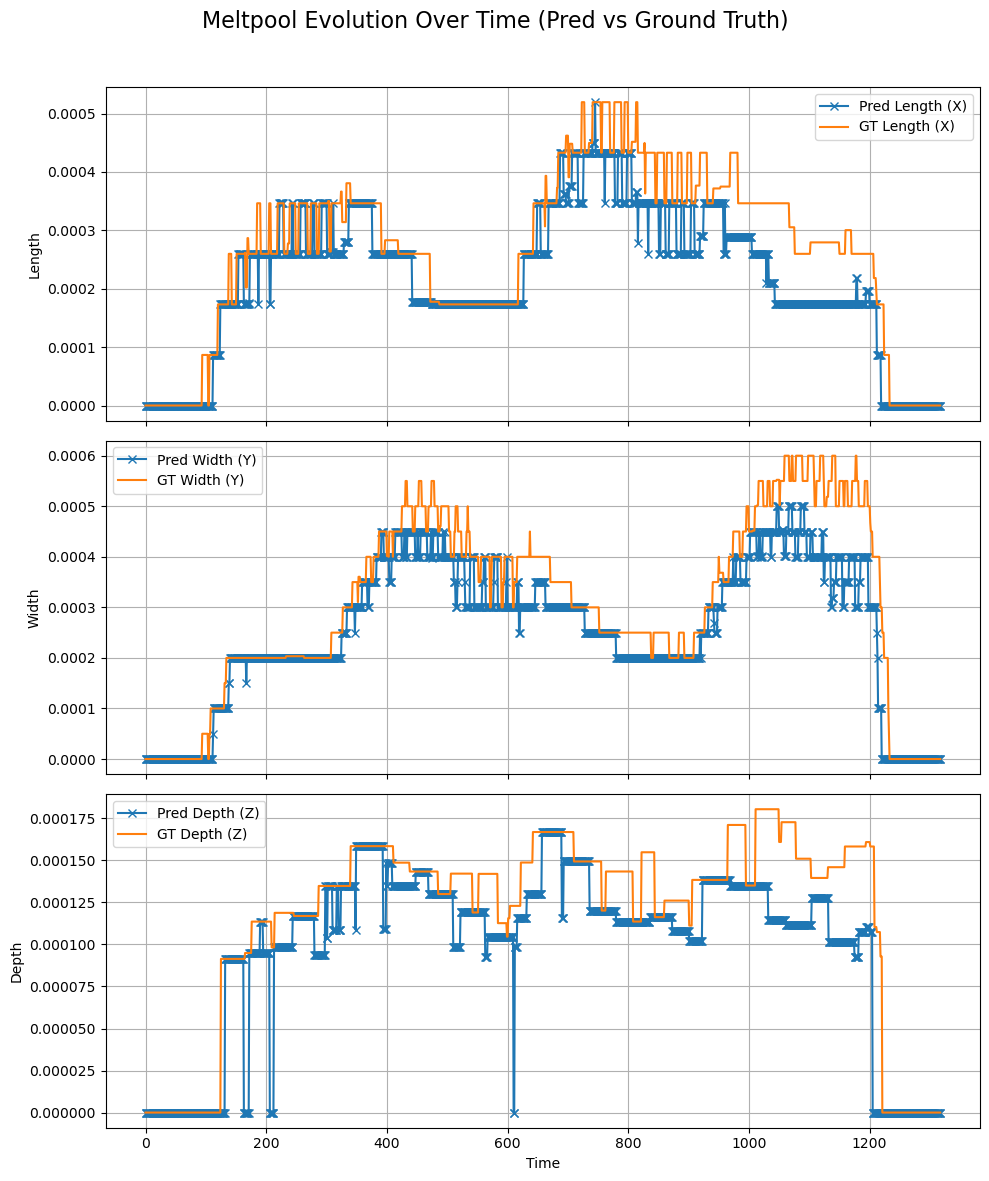

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig.suptitle("Meltpool Evolution Over Time (Pred vs Ground Truth)", fontsize=16)

# Length (X)
axes[0].plot(times, pred_melt_x_list, label='Pred Length (X)', marker='x')
axes[0].plot(times, gt_melt_x_list, label='GT Length (X)')
axes[0].set_ylabel("Length")
axes[0].legend()
axes[0].grid(True)

# Width (Y)
axes[1].plot(times, pred_melt_y_list, label='Pred Width (Y)', marker='x')
axes[1].plot(times, gt_melt_y_list, label='GT Width (Y)')
axes[1].set_ylabel("Width")
axes[1].legend()
axes[1].grid(True)

# Depth (Z)
axes[2].plot(times, pred_melt_z_list, label='Pred Depth (Z)', marker='x')
axes[2].plot(times, gt_melt_z_list, label='GT Depth (Z)')
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Depth")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


In [76]:
timestep = -1
mid_top_y = (mesh_pos[:, 1] ==  mesh_pos[:, 1]/2) & (mesh_pos[:, 2] ==  np.max(mesh_pos[:, 2]))
mid_top_line = mesh_pos[mid_top_y]
pred_mid_line = pred[timestep, mid_top_y]
gt_mid_line = gt[timestep, mid_top_y]

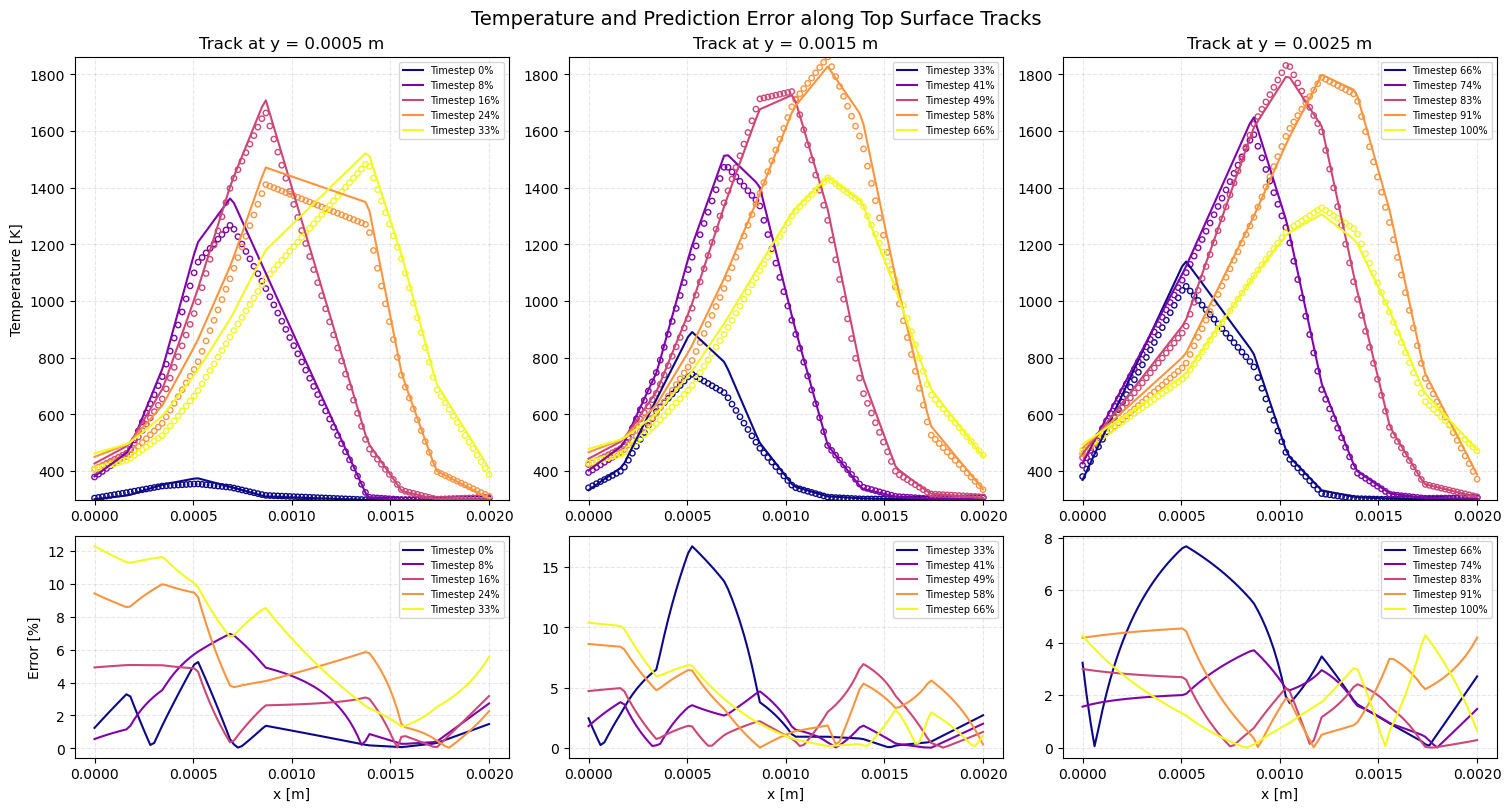

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator

# --- Extract mesh and data ---
mesh_pos = data["mesh_pos"]
pred = data["pred"]
gt = data["gt"]

# --- Top surface coordinates ---
top_z = np.max(mesh_pos[:, 2])
L_y_min, L_y_max = np.min(mesh_pos[:, 1]), np.max(mesh_pos[:, 1])
track_positions = [L_y_min + f * (L_y_max - L_y_min) for f in [5/30, 15/30, 25/30]]

tol = 1e-8
x_min, x_max = np.min(mesh_pos[:, 0]), np.max(mesh_pos[:, 0])
x_interp = np.linspace(x_min, x_max, 100)

# --- Create figure (thinner bottom row) ---
fig, axs = plt.subplots(
    2, 3, figsize=(15, 8),
    gridspec_kw={'height_ratios': [2, 1]},  # thinner 2nd row
    constrained_layout=True
)

colors = plt.cm.plasma(np.linspace(0, 1, 5))

# For global y-limits on the top row
global_min, global_max = np.inf, -np.inf

# --- Precompute all interpolated data to find global y-limits ---
interp_data = []
for i, y_target in enumerate(track_positions):
    track_mask = (np.abs(mesh_pos[:, 1] - y_target) < tol) & (np.abs(mesh_pos[:, 2] - top_z) < tol)
    x_nodes = mesh_pos[track_mask, 0]
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    
    for t in timesteps_to_plot:
        pred_vals = pred[t, track_mask]
        gt_vals = gt[t, track_mask]
        pred_interp = griddata(x_nodes, pred_vals, x_interp, method='linear')
        gt_interp = griddata(x_nodes, gt_vals, x_interp, method='linear')
        interp_data.append((i, t, pred_interp, gt_interp))
        global_min = min(global_min, np.nanmin([pred_interp, gt_interp]))
        global_max = max(global_max, np.nanmax([pred_interp, gt_interp]))

# --- Plot using precomputed data ---
for i, y_target in enumerate(track_positions):
    timesteps_to_plot = np.linspace((pred.shape[0]-1)/3 * (i), (pred.shape[0]-1)/3 * (i+1), 5, dtype=int)
    for color, (idx, t, pred_interp, gt_interp) in zip(colors, [d for d in interp_data if d[0] == i]):
        # --- Top row: Pred vs GT ---
        axs[0, i].scatter(x_interp, pred_interp, facecolors='none', edgecolors=color, s=15, linewidths=1)
        axs[0, i].plot(x_interp, gt_interp, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

        # --- Bottom row: Error [%] ---
        error = np.abs(pred_interp - gt_interp) / np.maximum(gt_interp, 1e-8) * 100
        axs[1, i].plot(x_interp, error, color=color, linestyle='-', 
                       label=f"Timestep {int((t/(pred.shape[0]-1))*100)}%")

    # --- Style each column ---
    axs[0, i].set_title(f"Track at y = {y_target:.4f} m")
    axs[0, i].set_ylabel("Temperature [K]" if i == 0 else "")
    axs[1, i].set_ylabel("Error [%]" if i == 0 else "")
    axs[1, i].set_xlabel("x [m]")

    # Coarse tick marks
    axs[1, i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axs[0, i].xaxis.set_major_locator(MaxNLocator(nbins=5))

    # Grid + legends
    axs[0, i].grid(True, linestyle='--', alpha=0.3)
    axs[1, i].grid(True, linestyle='--', alpha=0.3)
    axs[0, i].legend(fontsize=7, loc='best')
    axs[1, i].legend(fontsize=7, loc='best')

# --- Apply uniform y-limits to first row ---
for ax in axs[0, :]:
    ax.set_ylim(global_min, global_max)

# --- Global title ---
fig.suptitle("Temperature and Prediction Error along Top Surface Tracks", fontsize=14)
plt.show()


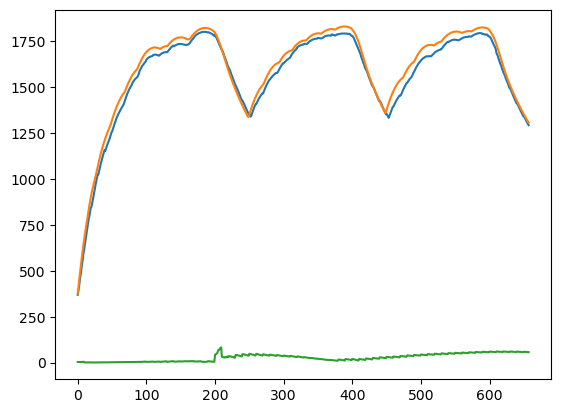

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# --- Inputs ---
pred = data["pred"]
gt = data["gt"]
mesh_pos = data["mesh_pos"]

plt.plot(range(pred.shape[0]), np.max(pred, axis = 1))
plt.plot(range(pred.shape[0]), np.max(gt, axis = 1))
plt.plot(range(pred.shape[0]), np.max(pred-gt, axis = 1))

# plt.plot(range(pred.shape[0]), np.min(pred, axis = 1))
# plt.plot(range(pred.shape[0]), np.min(gt, axis = 1))
# plt.plot(range(pred.shape[0]), np.min(pred-gt, axis = 1))
